## MODFLOW-NWT Problem 2

This example is based on problem 2 in Niswonger et al 2011, which
used the Newton-Raphson formulation to simulate dry cells under a
recharge pond. The problem is also described in McDonald et al 1991
and used the \MF rewetting option to rewet dry cells.

### Initial setup

Import dependencies, define the example name and workspace, and read settings from environment variables.

In [1]:
import os ; import flopy ; import matplotlib.pyplot as plt ; from matplotlib.colors import ListedColormap ; from pathlib import Path
from flopy.plot.styles import styles ; import pandas as pd ; import numpy as np 
from modflow_devtools.misc import get_env, timed ;
write = get_env("WRITE", True)
run = get_env("RUN", True)
plot = get_env("PLOT", True)
plot_show = get_env("PLOT_SHOW", True)
plot_save = get_env("PLOT_SAVE", True)

### Define parameters

Define model units, parameters and other settings.

In [2]:
sim_name = "08_p02" ; output_folder = Path("./08_ex-gwf-nwt-p02_o") ; output_folder.mkdir(exist_ok=True)  ;gwf_name = sim_name 
exe_name = 'E:\\15_REPOS\\00_BETAMI\\bin\\mf6.exe'                ; workspace = figs_path = output_folder 

In [3]:
# Model units
length_units = "feet"
time_units = "days"

# Scenario-specific parameters
parameters = {
    "ex-gwf-nwt-p02a": {
        "newton": "newton",
    },
    "ex-gwf-nwt-p02b": {
        "rewet": True,
        "wetfct": 0.5,
        "iwetit": 1,
        "ihdwet": 1,
        "wetdry": -0.5,
    },
}

# Model parameters
nper = 4  # Number of periods
nlay = 14  # Number of layers
nrow = 40  # Number of rows
ncol = 40  # Number of columns
delr = 125.0  # Column width ($ft$)
delc = 125.0  # Row width ($ft$)
top = 80.0  # Top of the model ($ft$)
k11 = 5.0  # Horizontal hydraulic conductivity ($ft/day$)
k33 = 0.25  # Horizontal hydraulic conductivity ($ft/day$)
ss = 0.0002  # Specific storage ($1/day$)
sy = 0.2  # Specific yield (unitless)
H1 = 25.0  # Constant head along left and lower edges and starting head ($ft$)
rech = 0.05  # Recharge rate ($ft/day$)


# Time discretization
tdis_ds = (
    (190.0, 10, 1.0),
    (518.0, 2, 1.0),
    (1921.0, 17, 1.0),
    (1.0, 1, 1.0),
)

# Calculate extents, and shape3d
extents = (0, delr * ncol, 20, 65)
shape3d = (nlay, nrow, ncol)

# Create the bottom
botm = np.arange(65.0, -5.0, -5.0)

# Create icelltype (which is the same as iconvert)
icelltype = 9 * [1] + 5 * [0]

# Constant head boundary conditions
chd_spd = []
for k in range(9, nlay, 1):
    chd_spd += [[k, i, ncol - 1, H1] for i in range(nrow - 1)]
    chd_spd += [[k, nrow - 1, j, H1] for j in range(ncol)]


# Recharge boundary conditions
rch_spd = []
for i in range(0, 2, 1):
    for j in range(0, 2, 1):
        rch_spd.append([0, i, j, rech])

# Solver parameters
nouter = 500
ninner = 100
hclose = 1e-6
rclose = 1000.0

### Model setup

Define functions to build models, write input files, and run the simulation.

In [4]:
def build_models(
    name,
    newton=False,
    rewet=False,
    wetfct=None,
    iwetit=None,
    ihdwet=None,
    wetdry=None,
):
    sim_ws = os.path.join(workspace, name)
    sim = flopy.mf6.MFSimulation(sim_name=sim_name, sim_ws=sim_ws, exe_name="mf6")
    flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_ds, time_units=time_units)
    if newton:
        newtonoptions = "newton"
        no_ptc = "ALL"
        complexity = "complex"
    else:
        newtonoptions = None
        no_ptc = None
        complexity = "simple"

    flopy.mf6.ModflowIms(
        sim,
        complexity=complexity,
        print_option="SUMMARY",
        no_ptcrecord=no_ptc,
        outer_maximum=nouter,
        outer_dvclose=hclose,
        inner_maximum=ninner,
        inner_dvclose=hclose,
        rcloserecord=rclose,
    )
    gwf = flopy.mf6.ModflowGwf(
        sim,
        modelname=sim_name,
        newtonoptions=newtonoptions,
    )
    flopy.mf6.ModflowGwfdis(
        gwf,
        length_units=length_units,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
    )
    if rewet:
        rewet_record = ["wetfct", wetfct, "iwetit", iwetit, "ihdwet", ihdwet]
        wetdry = 9 * [wetdry] + 5 * [0]
    else:
        rewet_record = None
    flopy.mf6.ModflowGwfnpf(
        gwf,
        rewet_record=rewet_record,
        icelltype=icelltype,
        k=k11,
        k33=k33,
        wetdry=wetdry,
    )
    flopy.mf6.ModflowGwfsto(
        gwf,
        iconvert=icelltype,
        ss=ss,
        sy=sy,
        steady_state={3: True},
    )
    flopy.mf6.ModflowGwfic(gwf, strt=H1)
    flopy.mf6.ModflowGwfchd(gwf, stress_period_data=chd_spd)
    flopy.mf6.ModflowGwfrch(gwf, stress_period_data=rch_spd)

    head_filerecord = f"{sim_name}.hds"
    flopy.mf6.ModflowGwfoc(
        gwf,
        head_filerecord=head_filerecord,
        saverecord=[("HEAD", "LAST")],
    )
    return sim


def write_models(sim, silent=True):
    sim.write_simulation(silent=silent)


@timed
def run_models(sim, silent=True):
    success, buff = sim.run_simulation(silent=silent)
    assert success, buff

### Plotting results

Define functions to plot model results.

In [5]:
figure_size = (6.3, 6.3)  ; masked_values = (1e30, -1e30)
def get_water_table(h, bot):
    imask = (h > -1e30) & (h <= bot)
    h[imask] = -1e30
    return np.amax(h, axis=0)
def plot_results(silent=True):
    if not plot:
        return

    verbose = not silent
    if verbose:
        verbosity_level = 1
    else:
        verbosity_level = 0

    with styles.USGSMap():
        # load the newton model
        name = next(iter(parameters.keys()))
        sim_ws = os.path.join(workspace, name)
        sim = flopy.mf6.MFSimulation.load(
            sim_name=sim_name, sim_ws=sim_ws, verbosity_level=verbosity_level
        )
        gwf = sim.get_model(sim_name)
        bot = gwf.dis.botm.array
        xnode = gwf.modelgrid.xcellcenters[0, :]

        # create MODFLOW 6 head object
        hobj = gwf.output.head()

        # get a list of times
        times = hobj.get_times()

        # load rewet model
        name = list(parameters.keys())[1]
        sim_ws = os.path.join(workspace, name)
        sim1 = flopy.mf6.MFSimulation.load(
            sim_name=sim_name, sim_ws=sim_ws, verbosity_level=verbosity_level
        )
        gwf1 = sim1.get_model(sim_name)

        # create MODFLOW 6 head object
        hobj1 = gwf1.output.head()

        # Create figure for simulation
        fig, axes = plt.subplots(
            ncols=1, nrows=4, sharex=True, figsize=figure_size, constrained_layout=False
        )

        # plot the results
        for idx, ax in enumerate(axes):
            # extract heads and specific discharge for newton model
            head = hobj.get_data(totim=times[idx])
            head = get_water_table(head, bot)

            # extract heads and specific discharge for newton model
            head1 = hobj1.get_data(totim=times[idx])
            head1 = get_water_table(head1, bot)

            # calculate mean error
            diff = np.abs(head - head1)
            # print("max", diff.max(), np.argmax(diff))
            me = diff.sum() / float(ncol * nrow)
            me_text = f"Mean absolute water-table error {me:.3f} feet"

            ax.set_xlim(extents[:2]) ; ax.set_ylim(extents[2:])  ; mm = flopy.plot.PlotCrossSection(model=gwf, ax=ax, extent=extents, line={"row": 1}) 
            mm.plot_bc("CHD", color="cyan")  ; mm.plot_grid(lw=0.5)  ; 
            ax.plot(xnode, head[0, :], lw=0.75, color="black", label="Newton-Raphson")
            ax.plot(xnode,head1[0, :],lw=0,marker="o",ms=4,mfc="none",mec="blue",label="Rewetting")
            letter = chr(ord("@") + idx + 1)
            styles.heading(letter=letter, ax=ax)
            styles.add_text(ax, text=me_text, x=1, y=1.01, ha="right", bold=False)
            styles.remove_edge_ticks(ax)

            # set fake y-axis label
            ax.set_ylabel(" ")

        # set fake x-axis label
        ax.set_xlabel(" ")

        ax = fig.add_subplot(1, 1, 1, frameon=False)
        ax.tick_params(
            labelcolor="none", top="off", bottom="off", left="off", right="off"
        )
        ax.set_xlim(0, 1)
        ax.set_xticks([0, 1])
        ax.set_xlabel("x-coordinate, in feet")
        ax.set_ylim(0, 1)
        ax.set_yticks([0, 1])
        ax.set_ylabel("Water-table elevation above arbitrary datum, in meters")
        styles.remove_edge_ticks(ax)

        if plot_show:
            plt.show()
        if plot_save:
            fpth = figs_path / f"{sim_name}-01.png"
            fig.savefig(fpth)

### Running the example

Define and invoke a function to run the example scenario, then plot results.

In [6]:
def scenario(idx, silent=True):
    key = list(parameters.keys())[idx]
    params = parameters[key].copy()
    sim = build_models(key, **params)
    if write:
        write_models(sim, silent=silent)
    if run:
        run_models(sim, silent=silent)

Run with Newton-Raphson.

In [7]:
scenario(0)

run_models took 9421.52 ms


Run with rewetting.

In [8]:
scenario(1)

run_models took 4139.56 ms


Plot results.

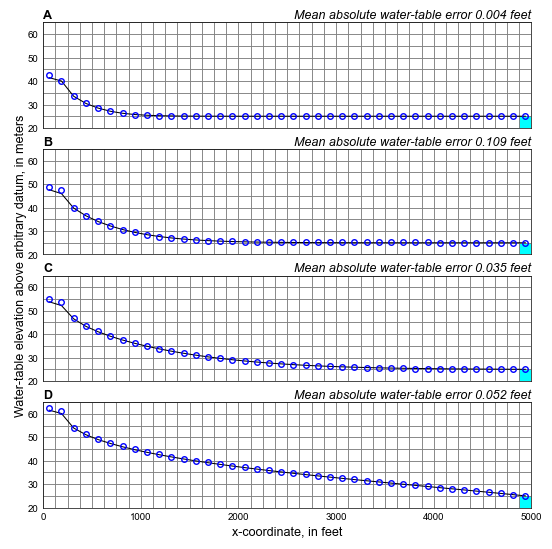

In [9]:
if plot:
    plot_results()